# MSc. Project

### Import Required Modules

In [2]:
import pandas as pd
import numpy as np
import json
import re
import html
from string import punctuation, digits
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import chain

## Amazon Data

### Reading Amazon Data

In [3]:
AMAZON_DATA_FILE_PATH = "..\..\AmazonReviewMetadata\\meta_Grocery_and_Gourmet_Food.json"
data = []
with open(AMAZON_DATA_FILE_PATH) as f:
    for line in f:
        data.append(json.loads(line.strip()))
amazon_data = pd.DataFrame.from_dict(data)
print(f"Columns in amazon dataset: {list(amazon_data.columns)}")

Columns in amazon dataset: ['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2', 'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details']


### Data Overview

In [4]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287051 entries, 0 to 287050
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   category         287051 non-null  object
 1   tech1            287051 non-null  object
 2   description      287051 non-null  object
 3   fit              287051 non-null  object
 4   title            287051 non-null  object
 5   also_buy         287051 non-null  object
 6   tech2            287051 non-null  object
 7   brand            287051 non-null  object
 8   feature          287051 non-null  object
 9   rank             287051 non-null  object
 10  also_view        287051 non-null  object
 11  main_cat         287051 non-null  object
 12  similar_item     287051 non-null  object
 13  date             287051 non-null  object
 14  price            287051 non-null  object
 15  asin             287051 non-null  object
 16  imageURL         287051 non-null  object
 17  imageURLHi

In [5]:
amazon_data.head(5)

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...",,"[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,[],,Ariola Imports,[],"165,181 in Grocery & Gourmet Food (","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,,,$41.91,0681727810,[],[],NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...",,"[Shipped from UK, please allow 10 to 21 busine...",,Trim Healthy Mama Xylitol,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",,,[],"315,867 in Grocery & Gourmet Food (",[],Grocery,,,,0853347867,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",,[Jazz up your cakes with a sparkling monogram ...,,Letter C - Swarovski Crystal Monogram Wedding ...,[],,Unik Occasions,[],"[>#669,941 in Kitchen & Dining (See Top 100 in...",[B07DXN65TF],Amazon Home,,"September 21, 2010",$29.95,1888861118,[],[],NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",,"[Large Letter - Height 4.75""]",,Letter H - Swarovski Crystal Monogram Wedding ...,[],,Other,"[Large Letter - Height 4.75""]","[>#832,581 in Kitchen & Dining (See Top 100 in...",[],Amazon Home,,"September 11, 2011",$11.45,1888861517,[],[],NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",,"[4.75""]",,Letter S - Swarovski Crystal Monogram Wedding ...,[],,Unik Occasions,"[4.75"" height]","[>#590,999 in Kitchen & Dining (See Top 100 in...",[],Amazon Home,,"September 11, 2011",$15.00,1888861614,[],[],NaN


In [6]:
amazon_data["main_cat"].value_counts().reset_index().head(5)

,index,main_cat
0,Grocery,261845
1,Amazon Home,8953
2,Health & Personal Care,8543
3,Toys & Games,1934
4,All Beauty,1604


In [8]:
# Since scope of the project is food products, filter the data to include only Grocery
amazon_data = amazon_data.loc[amazon_data["main_cat"]=="Grocery"].reset_index(drop=True)

In [9]:
# Investigating primitive type of data
print(f"{'Column Name':<20} | {'Pandas Data Type':<20} | {'Primitive Type':<20}")
print("-"*60)
amazon_data.attrs = {}
amazon_data.attrs["dtype"] = {}
for col in amazon_data.columns:
    primitive_types = set([type(i) for i in amazon_data[col]])
    print(f"{col:<20} | {str(amazon_data[col].dtype):<20} | {str([t.__name__ for t in primitive_types]):<20}")
    amazon_data.attrs["dtype"][col] = primitive_types

Column Name          | Pandas Data Type     | Primitive Type      
------------------------------------------------------------
category             | object               | ['list']            
tech1                | object               | ['str']             
description          | object               | ['list']            
fit                  | object               | ['str']             
title                | object               | ['str']             
also_buy             | object               | ['list']            
tech2                | object               | ['str']             
brand                | object               | ['str']             
feature              | object               | ['list']            
rank                 | object               | ['str', 'list']     
also_view            | object               | ['list']            
main_cat             | object               | ['str']             
similar_item         | object               | ['str']             
d

In [10]:
amazon_data.isna().sum()

category            0
tech1               0
description         0
fit                 0
title               0
also_buy            0
tech2               0
brand               0
feature             0
rank                0
also_view           0
main_cat            0
similar_item        0
date                0
price               0
asin                0
imageURL            0
imageURLHighRes     0
details            14
dtype: int64

In [11]:
for col in amazon_data.columns:
    if len(amazon_data.attrs["dtype"][col])>1:
        continue
    if list in amazon_data.attrs["dtype"][col]:
        amazon_data[col] = amazon_data[col].apply(lambda x: np.nan if len(x)==0 else x)
    elif str in amazon_data.attrs["dtype"][col]:
        amazon_data[col] = amazon_data[col].apply(lambda x: np.nan if len(x.strip())==0 else x)

In [12]:
amazon_data.isna().sum()

category                0
tech1              261777
description         31514
fit                261842
title                   3
also_buy           186218
tech2              261845
brand               10388
feature            256840
rank                    0
also_view          150585
main_cat                0
similar_item       261829
date               261459
price              141920
asin                    0
imageURL           122547
imageURLHighRes    122547
details                14
dtype: int64

In [13]:
amazon_data["brand"].value_counts().reset_index().head(5)

,index,brand
0,Unknown,1670
1,Black Tie Mercantile,1446
2,Trader Joe's,1227
3,McCormick,1029
4,The Nutty Fruit House,996


In [14]:
amazon_data["category"].value_counts().reset_index().head(5)

,index,category
0,"[Grocery & Gourmet Food, Candy & Chocolate, Ca...",7168
1,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",6574
2,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",6233
3,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",5041
4,"[Grocery & Gourmet Food, Candy & Chocolate, Ha...",4440


In [15]:
for col in ["title", "description", "brand"]:
    whitespace_chars = amazon_data[col].apply(
        lambda x: set(re.findall(r'\s', str(x))) if x else set()
    ).aggregate({'Whitespace Characters': lambda x: set.union(*x)})
    
    print(f"Whitespace characters found in column: '{col}': {whitespace_chars.values[0]}")

Whitespace characters found in column: 'title': {' ', '\t'}
Whitespace characters found in column: 'description': {' '}
Whitespace characters found in column: 'brand': {' '}


In [16]:
for col in ["title", "description", "brand"]:
    special_chars = amazon_data[col].apply(lambda x: set(re.findall(r'&\w+', str(x))) if x else set()).aggregate({'Whitespace Characters': lambda x: set.union(*x)})[0]
    print(f"Sample of HTML encoded characters in column: '{col}'")
    print(f"{'HTML Encoded Char':>20} | {'Decoded Char':>20}")
    print("-"*50)
    for ch in list(special_chars)[:5]:
        print(f"{ch.lower(): >20} | {html.unescape(ch.lower()): >20}")
    print(f"{'TOTAL': >20} | {len(special_chars): >20}")    

Sample of HTML encoded characters in column: 'title'
   HTML Encoded Char |         Decoded Char
--------------------------------------------------
             &eacute |                    é
              &aring |                    å
               &euro |                &euro
              &ecirc |                    ê
               &euml |                    ë
               TOTAL |                  102
Sample of HTML encoded characters in column: 'description'
   HTML Encoded Char |         Decoded Char
--------------------------------------------------
                  &s |                   &s
             &eacute |                    é
               &tmpl |                &tmpl
                  &j |                   &j
              &betty |               &betty
               TOTAL |                  261
Sample of HTML encoded characters in column: 'brand'
   HTML Encoded Char |         Decoded Char
--------------------------------------------------
               &prig |

In [17]:
col="description"
special_chars = amazon_data[col].apply(lambda x: set(re.findall(r'<\w*>', str(x))) if x else set()).aggregate({'Whitespace Characters': lambda x: set.union(*x)})[0]
print(f"HTML tags in column: '{col}': {special_chars}")

HTML tags in column: 'description': {'<tbody>', '<TR>', '<small>', '<h4>', '<i>', '<head>', '<h2>', '<h5>', '<blockquote>', '<LI>', '<colgroup>', '<lu>', '<bR>', '<style>', '<TD>', '<Kafemio>', '<em>', '<sub>', '<STRONG>', '<sup>', '<P>', '<u>', '<>', '<th>', '<li>', '<Li>', '<b>', '<Strong>', '<ul>', '<BR>', '<I>', '<xml>', '<B>', '<EOL>', '<h1>', '<div>', '<UL>', '<body>', '<ol>', '<Br>', '<br>', '<big>', '<td>', '<h3>', '<tr>', '<H4>', '<strong>', '<milk>', '<span>', '<H5>', '<center>', '<title>', '<table>', '<html>'}


In [20]:
amazon_data["category_count"] = amazon_data["category"].apply(lambda categories: len(categories))
amazon_data["category_count"].value_counts().reset_index()

,index,category_count
0,4,117371
1,3,75159
2,5,56903
3,2,10144
4,6,2259
5,9,4
6,8,3
7,10,1
8,11,1


In [21]:
amazon_data.drop("category_count", axis=1, inplace=True)

### Pre-Processing

In [22]:
class ColumnDropper():
    """Given a list of columns, this class is used to drop the columns"""
    def __init__(self, columns, include=False):
        """ If include is True, then the given columns will be retained and rest will be dropped
            If include is False, then the given columns will be dropped and rest will be retained"""
        self.columns = columns
        self.include=include
    
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        for column in X.columns:
            if (self.include) ^ (column in self.columns):
                X = X.drop(column, axis=1)
        return X

In [23]:
class RowDropper():
    """Given a list of columns, this class is used to drop rows with NaN in any of the listed columns"""
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        if not self.columns:
            self.columns = X.columns
        return self 

    def transform(self, X):
        X = X.dropna(subset=self.columns, how="any")
        X = X.drop_duplicates(subset=self.columns, keep="last").reset_index(drop=True)
        return X
    

In [24]:
class StringCleaner():
    """
    Given a list of columns, this class is used clean the string in the listed columns with following steps:
            1. Convert string to lower case
            2. Remove HTML encoded characters (characters starting with &)
            3. Remove HTML tags (characters between <>)
            4. Remove white spaces
            5. Remove punctuations and digits
            6. Replace empty strings with NaN
    """
    def __init__(self, columns):
        self.columns = columns
        self.translator = str.maketrans('', '', punctuation+digits)
    
    def fit(self, X, y=None):
        return self 
        
    def transform(self, X):
        for column in self.columns:
            # 1. Convert string to lower case
            X[column] = X[column].str.lower()
            
            # 2. Remove HTML encoded characters (characters starting with &)
            X[column] = X[column].apply(lambda s: re.sub('&\w+',' ',str(s)) if not pd.isna(s) else s)
            
            # 3. Remove HTML tags (characters between <>)
            X[column] = X[column].apply(lambda s: re.sub('<\w*>',' ',str(s)) if not pd.isna(s) else s)
            
            # 4. Remove white spaces
            X[column] = X[column].apply(lambda s: re.sub('\s+',' ',str(s)) if not pd.isna(s) else s)
            
            # 5. Remove punctuations and digits
            X[column] = X[column].apply(lambda s: s.translate(self.translator) if not pd.isna(s) else s)
            
            # 6. Replace empty strings with NaN
            X[column] = X[column].replace('', np.nan)
            X[column] = X[column].replace(' ', np.nan)
        return X
        

In [25]:
amazon_data.columns

Index(['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2',
       'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item',
       'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'details'],
      dtype='object')

In [26]:
# Dropping columns that are not relevant to the project
cd = ColumnDropper(columns=['category', 'description', 'title', 'brand', 'price', 'asin'], include=True)
amazon_data = cd.transform(amazon_data)
amazon_data.shape

(261845, 6)

In [27]:
amazon_data["description"] = amazon_data["description"].apply(lambda desc: ' '.join(desc) if type(desc)==list else desc)

In [28]:
# Dropping rows in which data is missing in crucial fields like 'title', 'description' or are duplicate records
rd = RowDropper(columns=["title", "description"])
amazon_data = rd.transform(amazon_data)
amazon_data.shape

(226619, 6)

In [29]:
# Cleaning columns which are string fields
sc = StringCleaner(columns=["description", "title", "brand"])
amazon_data = sc.transform(amazon_data)
amazon_data.head(5)

,category,description,title,brand,price,asin
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...",beemster gouda cheese aged months statements ...,beemster gouda aged months app lbs,ariola imports,$41.91,0681727810
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...",shipped from uk please allow to business day...,trim healthy mama xylitol,NaN,NaN,0853347867
2,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",lipton yellow label tea use only the finest te...,lipton yellow label tea loose tea g,lipton,$12.46,4639725043
3,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",lipton yellow label teabags uses a new way to ...,lipton yellow label finest blend tea bags tea...,lipton,$12.98,4639725183
4,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",wagh bakri masala chai s pack of statements r...,wagh bakri masala chai s pack of,wagh bakri,$25.93,4858582000


In [30]:
amazon_data = rd.transform(amazon_data)
amazon_data.shape

(223349, 6)

In [22]:
# duplicate_desc = amazon_data.groupby("title")["description", "asin", "brand", "price", "categories"].agg({
#                                                    'description': lambda x: ' '.join(x.unique()), 
#                                                    'asin': lambda x: x.iloc[-1],
#                                                    'brand': lambda x: ' '.join(x[~x.isna()].unique()),
#                                                    'price': lambda x: x.mean(),
#                                                    'categories': lambda x: list(chain(x))
#                                                   }).reset_index()

In [31]:
amazon_data = amazon_data.drop_duplicates(subset="description", keep="last").reset_index(drop=True)
amazon_data.shape

(203425, 6)

In [32]:
# As this category is mostly required for data visualisation later, this field will not be cleaned any further
amazon_data["category"].value_counts()

[Grocery & Gourmet Food, Candy & Chocolate, Candy & Chocolate Bars]                                                                                        5667
[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Tea, Tea Samplers]                                                                                5131
[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Coffee, Single-Serve Capsules & Pods]                                                             4585
[Grocery & Gourmet Food, Beverages, Coffee, Tea & Cocoa, Coffee, Ground Coffee]                                                                            3617
[Grocery & Gourmet Food, Candy & Chocolate, Hard Candy & Lollipops, Hard Candy]                                                                            3364
                                                                                                                                                           ... 
[Grocery & Gourmet Food, Frozen, Vegetab

In [33]:
amazon_data

,category,description,title,brand,price,asin
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...",beemster gouda cheese aged months statements ...,beemster gouda aged months app lbs,ariola imports,$41.91,0681727810
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...",shipped from uk please allow to business day...,trim healthy mama xylitol,NaN,NaN,0853347867
2,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",lipton yellow label tea use only the finest te...,lipton yellow label tea loose tea g,lipton,$12.46,4639725043
3,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",lipton yellow label teabags uses a new way to ...,lipton yellow label finest blend tea bags tea...,lipton,$12.98,4639725183
4,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",wagh bakri masala chai s pack of statements r...,wagh bakri masala chai s pack of,wagh bakri,$25.93,4858582000
...,...,...,...,...,...,...
203420,"[Grocery & Gourmet Food, Condiments & Salad Dr...",a unique blend of herbs just goddess from hamp...,hampton creek just goddess dressing fluid ounce,hampton creek,NaN,B01HJEO4QK
203421,"[Grocery & Gourmet Food, Jams, Jellies & Sweet...",caffarel fruit jellies are a product of italy ...,caffarel fruit jellies organic assorted g bag,caffarel,NaN,B01HJFBN9A
203422,"[Grocery & Gourmet Food, Condiments & Salad Dr...",hampton creeks just mayo truffle makes fancy f...,hampton creek spo just truffle mayo ounce,hampton creek,$10.89,B01HJFC704
203423,"[Grocery & Gourmet Food, Condiments & Salad Dr...",nothing compares with the classically zesty fl...,hampton creek just ranch dressing fluid ounce,hampton creek,$10.95,B01HJF6FRA


## Ontology Data

In [34]:
ONTOLOGY_DATA_PATH = "I:\MSc\Product Dataset\\"
product_tags = pd.read_csv(ONTOLOGY_DATA_PATH + "product_tags.csv")
preferences = pd.read_csv(ONTOLOGY_DATA_PATH + "preferences.csv")
field_test_preferences = pd.read_csv(ONTOLOGY_DATA_PATH + "field_test_preferences.csv")
preference_tags = pd.read_csv(ONTOLOGY_DATA_PATH + "preference_tags.csv")
preference_to_tags = pd.read_csv(ONTOLOGY_DATA_PATH + "preference_to_tags.csv")
associations = pd.read_csv(ONTOLOGY_DATA_PATH + "associations.csv")
field_test_preferences = field_test_preferences.iloc[:,:-3]

In [35]:
# Filtering data present in the latest version (i.e, not removed from any version)
product_tags = product_tags[product_tags["version removed"]==-1]
preferences = preferences[preferences["version removed"]==-1]
preference_tags = preference_tags[preference_tags["version removed"]==-1]
preference_to_tags = preference_to_tags[preference_to_tags["version removed"]==-1]
associations = associations[associations["version removed"]==-1]

# Dropping 'version removed' column
product_tags.drop("version removed", axis=1, inplace=True)
preferences.drop("version removed", axis=1, inplace=True)
preference_tags.drop("version removed", axis=1, inplace=True)
preference_to_tags.drop("version removed", axis=1, inplace=True)
associations.drop("version removed", axis=1, inplace=True)

In [36]:
summary = pd.DataFrame()
summary["Total No. of Records"] = [product_tags.shape[0], 
                    preferences.shape[0], 
                    field_test_preferences.shape[0], 
                    preference_tags.shape[0], 
                    preference_to_tags.shape[0],
                    associations.shape[0]]
summary["No. of Records (Latest)"] = [product_tags.shape[0], 
                    preferences.shape[0], 
                    field_test_preferences.shape[0], 
                    preference_tags.shape[0], 
                    preference_to_tags.shape[0],
                    associations.shape[0]]
summary["No. of Columns"] = [product_tags.shape[1], 
                    preferences.shape[1], 
                    field_test_preferences.shape[1], 
                    preference_tags.shape[1], 
                    preference_to_tags.shape[1],
                    associations.shape[1]]
summary["Column Names"] = [product_tags.columns.values, 
                    preferences.columns.values, 
                    field_test_preferences.columns.values, 
                    preference_tags.columns.values, 
                    preference_to_tags.columns.values,
                    associations.columns.values]
summary.index = ["product_tags", 
                    "preferences", 
                    "field_test_preferences", 
                    "preference_tags", 
                    "preference_to_tags",
                    "associations"]
summary

,Total No. of Records,No. of Records (Latest),No. of Columns,Column Names
product_tags,196,196,2,"[product tag id, product tag]"
preferences,25,25,2,"[preference id, preference]"
field_test_preferences,25,25,5,"[preference category, preference id, preferenc..."
preference_tags,61,61,2,"[preference tag id, preference tag]"
preference_to_tags,148,148,2,"[preference id, preference tag id]"
associations,795,795,3,"[preference tag id, product tag id, score]"


In [37]:
integrated_data = associations.merge(preference_to_tags, 
                   on="preference tag id", 
                   how="inner").merge(product_tags, 
                                      on="product tag id", 
                                      how="inner").merge(preference_tags, 
                                                         on="preference tag id", 
                                                         how="inner")

In [38]:
integrated_data = field_test_preferences.merge(integrated_data, on="preference id", how="left")

In [39]:
integrated_data.groupby(by=["preference category"]).size()

preference category
E. Environment    353
H. Health         115
Q. Quality         12
S. Social         404
dtype: int64

In [40]:
integrated_data

,preference category,preference id,preference,short id,is strict,preference tag id,product tag id,score,product tag,preference tag
0,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1336,0.991,egg organic,biodegradeable
1,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1337,0.991,egg free range,biodegradeable
2,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1338,0.991,egg barn,biodegradeable
3,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1339,0.991,egg enriched cages,biodegradeable
4,E. Environment,176,1. Products disposed in an environmentally fri...,E.1,False,37,1323,-0.951,packaging label A,biodegradeable
...,...,...,...,...,...,...,...,...,...,...
879,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1397,-0.250,organization/label tag 61,land
880,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1398,-0.620,organization/label tag 63,land
881,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1399,-0.070,organization/label tag 64,land
882,S. Social,196,6. Products from fair trade label companies,S.6,False,76,1400,0.290,organization/label tag 66,land


In [75]:
ontology_data = integrated_data.loc[~((integrated_data['product tag'].str.contains("organization")) 
                                      | (integrated_data['product tag'].str.contains("packaging")))].reset_index(drop=True)
ontology_data = ontology_data[[ "product tag", 
          "preference tag", "score", 
          "preference", "preference category"]]

In [76]:
sc = StringCleaner(["product tag", "preference tag"])
ontology_data = sc.transform(ontology_data)

In [77]:
integrated_data.groupby(by=["preference category", "preference"]).size().reset_index()["preference category"].value_counts()

H. Health         13
S. Social          6
E. Environment     3
Q. Quality         3
Name: preference category, dtype: int64

In [78]:
ontology_data.groupby(by=["preference category", "preference"]).size().reset_index()["preference category"].value_counts()

H. Health         13
S. Social          5
E. Environment     3
Q. Quality         3
Name: preference category, dtype: int64

In [79]:
integrated_data[~integrated_data["preference"].isin(ontology_data["preference"].unique())]["preference"].unique()[0]

'1. Products evaluated with auditing processes that rely on sustainability criteria.'

In [80]:
ontology_data

,product tag,preference tag,score,preference,preference category
0,egg organic,biodegradeable,0.991,1. Products disposed in an environmentally fri...,E. Environment
1,egg free range,biodegradeable,0.991,1. Products disposed in an environmentally fri...,E. Environment
2,egg barn,biodegradeable,0.991,1. Products disposed in an environmentally fri...,E. Environment
3,egg enriched cages,biodegradeable,0.991,1. Products disposed in an environmentally fri...,E. Environment
4,egg origin estonia,biodegradeable,0.991,1. Products disposed in an environmentally fri...,E. Environment
...,...,...,...,...,...
316,proactive supply chain investigation,transparency,0.200,5. Products from companies with transparent ac...,S. Social
317,egg origin estonia,fair trade,0.100,6. Products from fair trade label companies,S. Social
318,very transparent company,fair trade,0.300,6. Products from fair trade label companies,S. Social
319,transparent company,fair trade,0.100,6. Products from fair trade label companies,S. Social


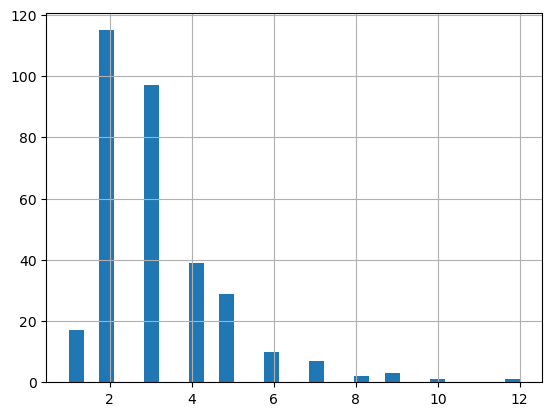

In [81]:
word_count = ontology_data["product tag"].apply(lambda s: len(s.strip().split()))
axes = word_count.hist(bins=30)

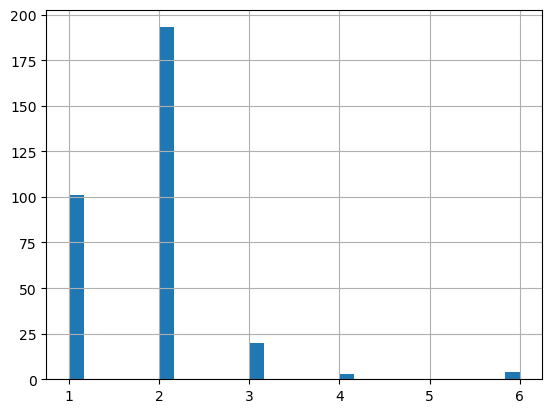

In [54]:
word_count = ontology_data["preference tag"].apply(lambda s: len(s.strip().split()))
axes = word_count.hist(bins=30)

In [144]:
product_associations = ontology_data.groupby(by=["product tag", "preference", "preference category"])['score'].agg([('sum',sum)]).reset_index()
product_associations["association"] = product_associations["sum"].apply(lambda x: 1 if x>=0 else -1)
product_associations = product_associations[["product tag", "preference", "association", "preference category"]]
product_associations["tag_type"] = "product"
product_associations.columns = ["tag", "preference", "association", "preference category", "tag_type"]
product_associations

,tag,preference,association,preference category,tag_type
0,allergen nuts,1. Allergen-free products,-1,H. Health,product
1,allergen nuts,3. High-protein products,1,H. Health,product
2,allergen soybeans and products thereof,1. Allergen-free products,-1,H. Health,product
3,allergen soybeans and products thereof,3. High-protein products,1,H. Health,product
4,allergens celery and products thereof,1. Allergen-free products,-1,H. Health,product
...,...,...,...,...,...
228,very transparent company,5. Products from companies with transparent ac...,1,S. Social,product
229,very transparent company,6. Products from fair trade label companies,1,S. Social,product
230,weak anti deforestation policy,1. Products disposed in an environmentally fri...,-1,E. Environment,product
231,weak anti deforestation policy,3. Products from companies that support animal...,-1,S. Social,product


In [145]:
preference_associations = ontology_data.groupby(by=["preference tag", "preference", "preference category"]).count().reset_index()
preference_associations["association"] = 1
preference_associations = preference_associations[["preference tag", "preference", "association", "preference category"]]
preference_associations["tag_type"] = "preference"
preference_associations.columns = ["tag", "preference", "association", "preference category", "tag_type"]
preference_associations

,tag,preference,association,preference category,tag_type
0,allergen free,1. Allergen-free products,1,H. Health,preference
1,animal rights,3. Products from companies that support animal...,1,S. Social,preference
2,antioxidants,8. Products rich in antioxidants,1,H. Health,preference
3,biodegradeable,1. Products disposed in an environmentally fri...,1,E. Environment,preference
4,biodynamic and permaculture,1. Products disposed in an environmentally fri...,1,E. Environment,preference
5,certified quality,1. Award winning or high quality certified pro...,1,Q. Quality,preference
6,climate,2. Products produced and distributed in an env...,1,E. Environment,preference
7,close production,2. Products produced and distributed in an env...,1,E. Environment,preference
8,colabelling environment,2. Products produced and distributed in an env...,1,E. Environment,preference
9,country of origin of the user,3. Locally originated and domestic products,1,Q. Quality,preference


In [146]:
vocab = pd.concat([product_associations, preference_associations], ignore_index=True)
vocab.sort_values(by="preference")

,tag,preference,association,preference category,tag_type
0,allergen nuts,1. Allergen-free products,-1,H. Health,product
29,austrian allergens lupins and products derived...,1. Allergen-free products,-1,H. Health,product
28,austrian allergens fish and derived products,1. Allergen-free products,-1,H. Health,product
27,austrian allergens eggs of poultry and product...,1. Allergen-free products,-1,H. Health,product
26,austrian allergens crustaceans and products de...,1. Allergen-free products,-1,H. Health,product
...,...,...,...,...,...
188,other additives,9. Products without artificial colours or flav...,-1,H. Health,product
203,sweeteners,9. Products without artificial colours or flav...,-1,H. Health,product
45,colours,9. Products without artificial colours or flav...,-1,H. Health,product
275,without colors,9. Products without artificial colours or flav...,1,H. Health,preference


In [147]:
vocab.groupby("preference")["tag"].agg([('count', 'count')]).reset_index()

,preference,count
0,1. Allergen-free products,31
1,1. Award winning or high quality certified pro...,2
2,1. Products disposed in an environmentally fri...,36
3,10. Products without preservatives,6
4,"11. Products without thickeners, stabilizers o...",3
5,12. Vegan products,21
6,13. Vegetarian products,17
7,2. Fresh products,3
8,2. Gluten-free products,10
9,2. Products from companies that actively contr...,4


In [148]:
vocab.groupby("preference category")["tag"].agg([('count', 'count')]).reset_index()

,preference category,count
0,E. Environment,75
1,H. Health,128
2,Q. Quality,10
3,S. Social,67


In [149]:
pd.DataFrame(vocab).to_excel("vocab.xlsx")

## Manual Processing

In [154]:
vocab = pd.read_excel("vocab_updated.xlsx")
vocab.drop(columns=vocab.columns[0], axis=1, inplace=True)
vocab

,tag,preference,association,preference category,tag_type,update_code,comment
0,allergen nuts,1. Allergen-free products,-1,H. Health,product,0,No Change
1,allergen nuts,3. High-protein products,1,H. Health,product,0,No Change
2,allergen soybeans and products thereof,1. Allergen-free products,-1,H. Health,product,0,No Change
3,allergen soybeans and products thereof,3. High-protein products,1,H. Health,product,0,No Change
4,allergens celery and products thereof,1. Allergen-free products,-1,H. Health,product,0,No Change
...,...,...,...,...,...,...,...
329,biodegradeable material,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for biodegradable
330,recycling done,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for recycling
331,recyclable packaging,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for recycling
332,recyclable material,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for recycling


| Update Code | Code Description | Possible Reasons |
|---|---|---|
|0 | No Change | No changes done to the tag |
|1 | New tag added | Alternate tags for existing tags or negation of tags by using keywords like "without", "not" or "no" |
|2 | Updated | Spelling corrections or converting keyword from unigram to bi-gram |
|-1 | Removed | Specific to the experiment conducted in Estonian and Austrian market or non-English words or redundant tags |


In [155]:
vocab["update_code"].value_counts()

 0    253
-1     37
 1     36
 2      8
Name: update_code, dtype: int64

In [156]:
vocab["comment"].value_counts()

No Change                                                    253
Negation                                                      20
specific to Austrian market (where the exp was conducted)     13
specific to Estonian market (where the exp was conducted)     13
Not English word (mostly German)                               6
Alternate tag to vegan                                         6
Made it bi-gram                                                5
Updated spelling                                               3
Redundant                                                      3
Alternate tag for recycling                                    3
specific to exp conducted                                      2
Alternate tag to lactose free                                  2
Alternate tag to vegeterian                                    2
Alternate tag for biodegradable                                2
Alternate tag for sponsor                                      1
Name: comment, dtype: int

In [157]:
vocab[vocab["update_code"]>=0]

,tag,preference,association,preference category,tag_type,update_code,comment
0,allergen nuts,1. Allergen-free products,-1,H. Health,product,0,No Change
1,allergen nuts,3. High-protein products,1,H. Health,product,0,No Change
2,allergen soybeans and products thereof,1. Allergen-free products,-1,H. Health,product,0,No Change
3,allergen soybeans and products thereof,3. High-protein products,1,H. Health,product,0,No Change
4,allergens celery and products thereof,1. Allergen-free products,-1,H. Health,product,0,No Change
...,...,...,...,...,...,...,...
329,biodegradeable material,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for biodegradable
330,recycling done,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for recycling
331,recyclable packaging,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for recycling
332,recyclable material,1. Products disposed in an environmentally fri...,1,E. Environment,preference,1,Alternate tag for recycling


## Keyword Extraction

In [142]:
tfidf = TfidfVectorizer(ngram_range=(2,3), stop_words='english')

In [169]:
onto_tfidf = tfidf.fit_transform(ontology_data["product tag"])
onto_tfidf

<321x297 sparse matrix of type '<class 'numpy.float64'>'
	with 790 stored elements in Compressed Sparse Row format>

In [170]:
df_onto=pd.DataFrame()
for i, col in enumerate(tfidf.get_feature_names_out()):
    df_onto[col] = pd.Series(pd.arrays.SparseArray(onto_tfidf[:, i].toarray().ravel()))

In [144]:
desc_tfidf = tfidf.transform(amazon_data["description"])
desc_tfidf

<203479x297 sparse matrix of type '<class 'numpy.float64'>'
	with 34402 stored elements in Compressed Sparse Row format>

In [145]:
df_desc=pd.DataFrame()
for i, col in enumerate(tfidf.get_feature_names_out()):
    df_desc[col] = pd.Series(pd.arrays.SparseArray(desc_tfidf[:, i].toarray().ravel()))

In [146]:
df_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203479 entries, 0 to 203478
Columns: 297 entries, allergen nuts to weak anti deforestation
dtypes: Sparse[float64, nan](297)
memory usage: 691.6 MB


In [147]:
print(f"Number of descriptions with zero keywords in the vocab: {df_desc[df_desc.sum(axis=1)==0].shape[0]} out of {df_desc.shape[0]}")

Number of descriptions with zero keywords in the vocab: 174746 out of 203479


In [148]:
(df_desc>0).sum(axis=1).sort_values(ascending=False)

153645    6
56389     5
25068     5
5534      5
7059      5
         ..
73878     0
73880     0
73881     0
73882     0
203478    0
Length: 203479, dtype: int64

In [149]:
df_desc.iloc[153645][df_desc.iloc[153645]>0]

cholesterol free      0.415764
gluten free           0.415764
low fat               0.415764
low saturated         0.415764
low saturated fats    0.415764
saturated fats        0.368376
Name: 153645, dtype: Sparse[float64, nan]

In [150]:
product = np.dot(desc_tfidf, products_tfidf.T)
product.shape

(203479, 321)

In [151]:
df_product=pd.DataFrame()
for i in range(product.shape[1]):
    df_product[i] = pd.Series(pd.arrays.SparseArray(product[:, i].toarray().ravel()))
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203479 entries, 0 to 203478
Columns: 321 entries, 0 to 320
dtypes: Sparse[float64, nan](321)
memory usage: 747.5 MB


In [152]:
df_product

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
(df_product>0).sum(axis=1).sort_values(ascending=False)

72578     32
148276    20
47981     20
120041    19
8158      19
          ..
73878      0
73880      0
73881      0
73882      0
203478     0
Length: 203479, dtype: int64

In [154]:
sample = (df_product>0).sum(axis=1).sort_values(ascending=False)[:5].index
df_product.iloc[sample][df_product.iloc[sample]>0]#.sort_values(ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
72578,0.696468,0.414299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148276,0.584764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47981,NaN,0.211792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120041,NaN,0.190917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8158,NaN,0.118857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [155]:
ontology_data.iloc[df_product.iloc[72578][df_product.iloc[72578]>0].sort_values(ascending=False).index]

,product tag id,product tag,preference tag id,preference tag,score,preference id,preference,preference category,short id,is strict
0,1336,egg organic,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
242,1336,egg organic,42,animal rights,0.991,195,3. Products from companies that support animal...,S. Social,S.3,False
194,1336,egg organic,28,vegan,-1.000,188,12. Vegan products,H. Health,H.12,True
164,1336,egg organic,49,lactose free,0.991,180,4. Lactose-free products,H. Health,H.4,True
253,1336,egg organic,55,green farming,0.991,195,3. Products from companies that support animal...,S. Social,S.3,False
156,1336,egg organic,45,high protein,0.100,181,3. High-protein products,H. Health,H.3,False
145,1336,egg organic,44,gluten free,0.991,179,2. Gluten-free products,H. Health,H.2,True
264,1336,egg organic,28,vegan,-1.000,195,3. Products from companies that support animal...,S. Social,S.3,False
100,1336,egg organic,55,green farming,0.991,178,3. Sustainably farmed products,E. Environment,E.3,False
214,1336,egg organic,29,vegetarian,0.991,189,13. Vegetarian products,H. Health,H.13,True


In [156]:
amazon_data.iloc[72578]["description"]

'life is about balance and eating well with wolfgang puck soup look no further made with the finest organic ingredients these restaurantquality premium soups will be sure to delight your taste buds its about time you bought wolfgang pucks signature tastes into your home live love eatbrbrwolfgang puck organic free range chicken  dumplings soup is crafted with organic chicken stock succulent pieces of chicken organic vegetables and tender dumplings enhance the flavor by garnishing with a sprinkle of parsley ingredients water organic vegetable stock water organic carrots organic onions organic celery organic carrots organic roasted potatoes organic chicken meat organic dumplings water organic wheat flour organic eggs organic wheat flour contains less than  of organic cream from organic milk organic celery organic tapioca starch organic chicken fat organic butter organic cream from organic milk salt salt organic onions organic chicken with juices organic chicken flavor organic natural flav

In [157]:
df_desc.iloc[72578][df_desc.iloc[72578]>0]

egg organic    0.696468
free range     0.717588
Name: 72578, dtype: Sparse[float64, nan]

In [ ]:
df_product

In [165]:
temp = df_product.sum(axis=1)
temp[temp==0].shape, temp[temp>0].shape, 

((174746,), (28733,))

In [168]:
amazon_data.iloc[2]["description"]

'lipton yellow label tea use only the finest tea leaves these leaves are specially cut to expose more of the juices then they are curled into tiny beads to seal in more of the flavor enjoy a hot cup of lipton yellow label tea today tea statements regarding dietary supplements have not been evaluated by the fda and are not intended to diagnose treat cure or prevent any disease or health condition'

In [177]:
keywords = df_desc.iloc[72578][df_desc.iloc[72578]>0].index
ontology_data.iloc[df_onto[df_onto[keywords[0]]>0][keywords[0]].index]

,product tag id,product tag,preference tag id,preference tag,score,preference id,preference,preference category,short id,is strict
0,1336,egg organic,37,biodegradeable,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
13,1336,egg organic,63,sustainable farming,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
25,1336,egg organic,55,green farming,0.991,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
36,1336,egg organic,62,biodynamic and permaculture,0.300,176,1. Products disposed in an environmentally fri...,E. Environment,E.1,False
62,1336,egg organic,36,low co footprint,0.200,177,2. Products produced and distributed in an env...,E. Environment,E.2,False
89,1336,egg organic,43,farming regulations,0.991,178,3. Sustainably farmed products,E. Environment,E.3,False
100,1336,egg organic,55,green farming,0.991,178,3. Sustainably farmed products,E. Environment,E.3,False
145,1336,egg organic,44,gluten free,0.991,179,2. Gluten-free products,H. Health,H.2,True
156,1336,egg organic,45,high protein,0.100,181,3. High-protein products,H. Health,H.3,False
164,1336,egg organic,49,lactose free,0.991,180,4. Lactose-free products,H. Health,H.4,True
